# Using sparse linear models (LASSO) to interpret the results

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/expl_lasso.ipynb)

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt
import mlcolvar.utils.plot

# Set seed for reproducibility
torch.manual_seed(1)

In this notebook we show how sparse linear models can be used to interpret NN-based ones, in the spirit of this [paper](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.2c00393).
As example we train an autoencoder CV on the [intermolecular aldol reaction](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/examples/ex_DeepLDA.ipynb) from the [examples](https://mlcolvar.readthedocs.io/en/stable/examples.html), and we try to interpret the results, using both a classification or a regression linear model.

## Train a ML CV

In [2]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "https://raw.githubusercontent.com/luigibonati/data-driven-CVs/master/aldol/1_unbiased/INPUTS.R", 
              "https://raw.githubusercontent.com/luigibonati/data-driven-CVs/master/aldol/1_unbiased/INPUTS.P" ]

n_states = len(filenames)

# load dataset
dataset, df = create_dataset_from_files(filenames,
                                        filter_args={'regex':'cc|oo|co|ch|oh' }, # select contacts 
                                        create_labels=True,
                                        return_dataframe=True, 
                                        )

datamodule = DictModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5001, 43)
Class 1 dataframe shape:  (5001, 43)

 - Loaded dataframe (10002, 43): ['time', 'cc2.0', 'cc2.1', 'cc2.2', 'oo2.0', 'co2.0', 'co2.1', 'co2.2', 'co2.3', 'co2.4', 'co2.5', 'ch2.0', 'ch2.1', 'ch2.2', 'ch2.3', 'ch2.4', 'ch2.5', 'ch2.6', 'ch2.7', 'ch2.8', 'ch2.9', 'ch2.10', 'ch2.11', 'ch2.12', 'ch2.13', 'ch2.14', 'ch2.15', 'ch2.16', 'ch2.17', 'oh2.0', 'oh2.1', 'oh2.2', 'oh2.3', 'oh2.4', 'oh2.5', 'oh2.6', 'oh2.7', 'oh2.8', 'oh2.9', 'oh2.10', 'oh2.11', 'walker', 'labels']
 - Descriptors (10002, 40): ['cc2.0', 'cc2.1', 'cc2.2', 'oo2.0', 'co2.0', 'co2.1', 'co2.2', 'co2.3', 'co2.4', 'co2.5', 'ch2.0', 'ch2.1', 'ch2.2', 'ch2.3', 'ch2.4', 'ch2.5', 'ch2.6', 'ch2.7', 'ch2.8', 'ch2.9', 'ch2.10', 'ch2.11', 'ch2.12', 'ch2.13', 'ch2.14', 'ch2.15', 'ch2.16', 'ch2.17', 'oh2.0', 'oh2.1', 'oh2.2', 'oh2.3', 'oh2.4', 'oh2.5', 'oh2.6', 'oh2.7', 'oh2.8', 'oh2.9', 'oh2.10', 'oh2.11']


In [3]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback
from mlcolvar.cvs import AutoEncoderCV

# define model
n_input           = dataset['data'].shape[-1]
nodes             = [40,30,30,1]
nn_args           = {'activation': 'shifted_softplus'}
options           = {'encoder': nn_args}

model = AutoEncoderCV(nodes, options=options)

# define trainer
trainer = lightning.Trainer(accelerator='cpu', max_epochs=500, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/mambaforge/envs/mlcolvar110/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/lbonati@iit.local/software/mambaforge/envs/mlcolvar110/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type          | Params | In sizes | Out sizes


/home/lbonati@iit.local/software/mambaforge/envs/mlcolvar110/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 27.84it/s, v_num=44] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s, v_num=44]


### Create labels based on CV distribution

If we visualize the CV distribution, we realize that there are two distinct states, which we can label based on the value of the CV (greater or smaller than 0).

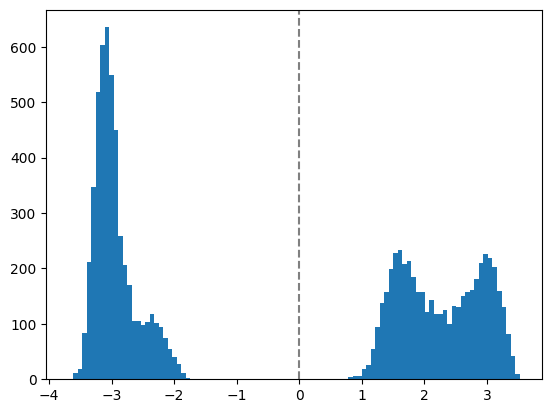

In [4]:
with torch.no_grad():
    s = model(dataset['data']).cpu().numpy()

plt.hist(s,bins=100)
plt.axvline(0,linestyle='dashed',color='grey')
plt.show()

In [5]:
labels = np.zeros_like(s)
labels[np.argwhere(s<0)] = 1
labels[np.argwhere(s>0)] = 2

dataset['labels'] = torch.Tensor(labels).squeeze(-1)

# Sparse linear models

Sparsity in linear models can be enforced via L1 regularization on the weights. In this way, we can obtain a parametrization of the model with only a few non-zero coefficients, which is more interpretable. The number of non-zero coefficients depends on the magnitutde of the regularization strength.

## LASSO classifier

We can interpret the metastable states that we found in the CV space by training a lasso classifier on the labeled dataset, and finding a minimal set of descriptors that can distinguish one state from another.

**Scoring function**

To find the optimal value of the regularization strength, we use the following scoring function, which balances the accuracy and the number of non-zero coefficients. In particular, it retains a feature only if it increases the classification accuracy by more than 1%. In addition, a minimum number of features can be requested.
$$\text{score} = - (1-\text{accuracy})*100 - \left|n-\text{min\_features}\right| $$

**Train classifier**

In [6]:
from mlcolvar.explain.lasso import lasso_classification

classifier, feats, coeffs = lasso_classification(dataset, plot = False)

======= LASSO results (2) ========
- Regularization : 0.00025719
- Score          : -1.00
- Accuracy       : 100.00%
- # features     : 1

Features: 
(1) cc2.1        : -0.442769



**Plot**

In order to find the best classifier, we can look at the following plots as a function of the (inverse) regularization strength.
1. values of the coefficients
2. score 
3. number of features

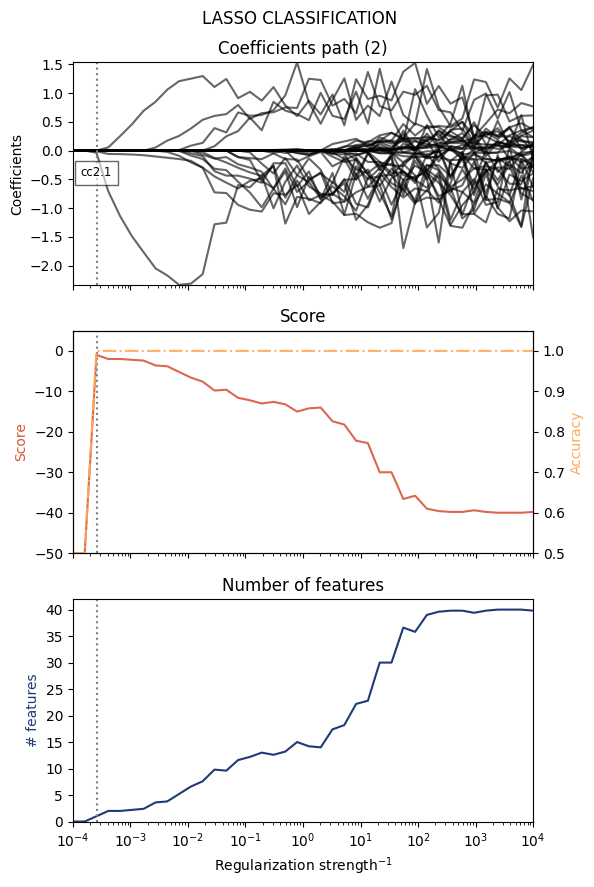

In [7]:
from mlcolvar.explain.lasso import plot_lasso_classification

fig,axs = plot_lasso_classification(classifier,feats,coeffs)

We can specify the range of the regularization parameters with the `Cs` argument (the inverse of the regularization strength).

======= LASSO results (2) ========
- Regularization : 0.00025719
- Score          : -1.00
- Accuracy       : 100.00%
- # features     : 1

Features: 
(1) cc2.1        : -0.442827



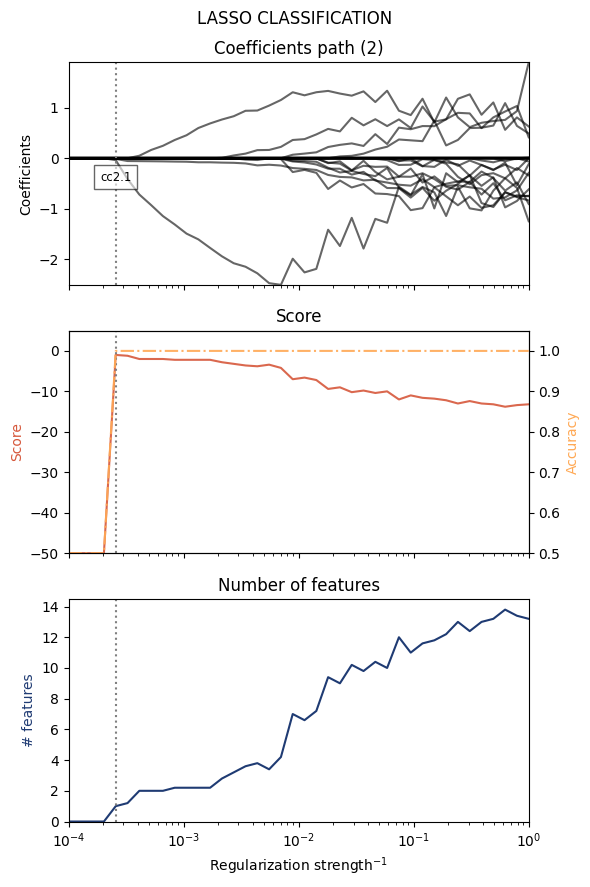

In [8]:
from mlcolvar.explain.lasso import lasso_classification

classifier, feats, coeffs = lasso_classification(dataset, Cs=np.logspace(-4,0,40))

Or even a single value

In [9]:
classifier, feats, coeffs = lasso_classification(dataset, Cs = [1e-3], plot=False)

======= LASSO results (2) ========
- Regularization : 0.00100000
- Score          : -2.20
- Accuracy       : 99.80%
- # features     : 2

Features: 
(1) cc2.1        : -1.590576
(2) oh2.3        : 0.607862



Alternatively, the  `min_features` keyword can be used to request a model with a given number of features.

In [10]:
from mlcolvar.explain.lasso import lasso_classification

classifier, feats, coeffs = lasso_classification(dataset, min_features=3, plot=False)

======= LASSO results (2) ========
- Regularization : 0.00437548
- Score          : -0.40
- Accuracy       : 99.60%
- # features     : 3

Features: 
(1) cc2.1        : -2.603686
(2) oh2.3        : 1.036645
(3) co2.5        : 0.154589



Once we have found a set of relevant features, we can plot their distribution to see their values in the different states.


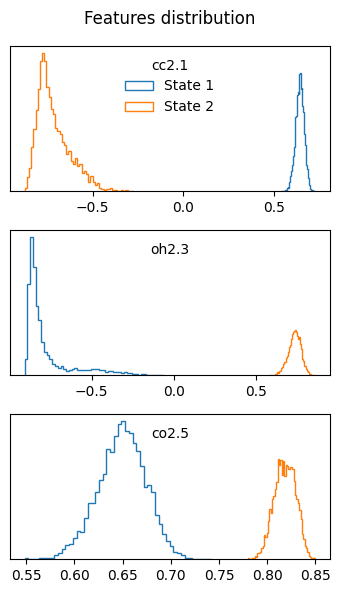

In [11]:
from mlcolvar.explain import plot_features_distribution
    
plot_features_distribution(dataset,features=feats[2])

## LASSO regression

Another way to interpret the results is by training a linear model to approximate the non-linear CV, in terms of a few descriptors. We can do so with a lasso regressor, optimized with the following loss:

$$\frac{1}{2\ \text{n\_samples}} ||y - Xw||^2_2 + \alpha\ ||w||_1$$

Being a regression task, we need a dataset with a "target" field, in this case this is the value of the CV. 

In [12]:
with torch.no_grad():
    dataset['target'] = model(dataset['data']).squeeze(-1)

**Train the lasso regressor**

As before, we can look at the values of the cofficients, the score (in this case it is directly the objective) and the number of selected features.

========= LASSO results ==========
- Regularization : 0.00262542
- Score          : 0.99858080
- # features     : 25

======= Relevant features =======
(1) oh2.9        : -0.860057
(2) oh2.3        : 0.785916
(3) ch2.15       : -0.308029
(4) ch2.9        : 0.243112
(5) oh2.6        : -0.124784
(6) oh2.1        : -0.111379
(7) oh2.7        : -0.082770
(8) ch2.4        : -0.079014
(9) oh2.0        : -0.072904
(10) oo2.0        : -0.066918
(11) ch2.11       : -0.059698
(12) ch2.12       : -0.059411
(13) co2.5        : 0.057554
(14) oh2.8        : -0.052454
(15) co2.2        : -0.038305
(16) co2.0        : 0.033872
(17) co2.4        : -0.018800
(18) ch2.6        : 0.017482
(19) ch2.1        : 0.008754
(20) oh2.4        : -0.007725
(21) ch2.7        : 0.007211
(22) ch2.2        : -0.005044
(23) ch2.8        : 0.001218
(24) ch2.10       : -0.000993
(25) oh2.10       : -0.000036


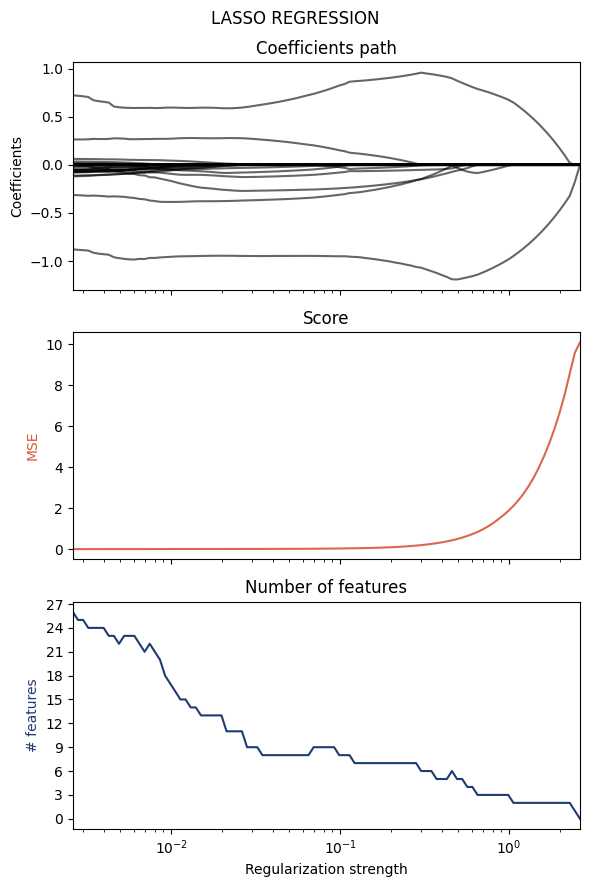

In [13]:
from mlcolvar.explain.lasso import lasso_regression

regressor, feats, coeffs = lasso_regression(dataset, alphas=None, plot=True)

Here the keyword `alphas` (regularization strength) can be used to select a given model:

In [14]:
regressor, feats, coeffs = lasso_regression(dataset, alphas=[0.1])

========= LASSO results ==========
- Regularization : 0.10000000
- Score          : 0.99583257
- # features     : 8

======= Relevant features =======
(1) oh2.9        : -0.950432
(2) oh2.3        : 0.823056
(3) ch2.15       : -0.310787
(4) co2.1        : -0.243188
(5) ch2.9        : 0.151098
(6) ch2.12       : -0.081146
(7) cc2.2        : -0.025074
(8) ch2.14       : -0.018452
Plotting is not available, as the regressor has been optimized with a single regularization value.


To understand the quality of the approximated CV, we can compare the linear models with different regularization strenghts with target CV:

/home/lbonati@iit.local/software/mambaforge/envs/mlcolvar110/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.62178373336792, tolerance: 4.922430515289307
  model = cd_fast.enet_coordinate_descent_gram(
/home/lbonati@iit.local/software/mambaforge/envs/mlcolvar110/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.420183181762695, tolerance: 5.466958045959473
  model = cd_fast.enet_coordinate_descent_gram(
/home/lbonati@iit.local/software/mambaforge/envs/mlcolvar110/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.153196334838867, tolerance: 5.708519458770752


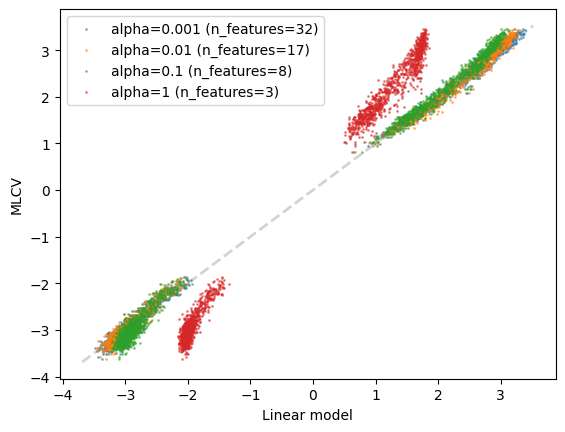

In [15]:
# standardize inputs

with torch.no_grad():
    X = dataset['data'].numpy()
    y = dataset['target'].numpy()

from sklearn.preprocessing import StandardScaler 
X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

# test different values of alpha

for alpha in [1e-3,1e-2,1e-1,1]:
    regressor, feats, coeffs = lasso_regression(dataset, alphas=[alpha],print_info=False,plot=False)

    y_pred = regressor.predict(X)

    plt.scatter(y_pred[::5], y[::5],s=1,label=f'alpha={alpha} (n_features={len(coeffs)})',alpha=0.5)
    
plt.xlabel('Linear model')
plt.ylabel('MLCV')
plt.plot([y.min(),y.max()],[y.min(),y.max()],linewidth=2,color='lightgrey',zorder=0,linestyle='dashed')
plt.legend()

This picture tells us that already a model with three features can qualitatively capture the ML-based CV, while adding a few more allows to more faithfully approximate it. 